# Week Five - Part 2 - Assignment: Document Classification

Group Member: Bryan Persaud, Matthew Baker, Zhi Ying Chen

It can be useful to be able to classify new "test" documents using already classified "training" documents.  A common example is using a corpus of labeled spam and ham (non-spam) e-mails to predict whether or not a new document is spam.  Here is one example of such data:  UCI Machine Learning Repository: Spambase Data Set

For this project, you can either use the above dataset to predict the class of new documents (either withheld from the training dataset or from another source such as your own spam folder).

For more adventurous students, you are welcome (encouraged!) to come up a different set of documents (including scraped web pages!?) that have already been classified (e.g. tagged), then analyze these documents to predict how new documents should be classified.

In [56]:
import nltk
from collections import Counter
from nltk import download
from nltk.corpus import names
from nltk.util import ngrams
from nltk.tokenize.sonority_sequencing import SyllableTokenizer
from nltk.classify import apply_features
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import numpy as np

In [57]:
# load the data and take a quick look at the data
spambase = pd.read_csv("https://raw.githubusercontent.com/Zchen116/data-620/main/spambase.data")

spambase.head()

,0,0.64,0.64.1,0.1,0.32,0.2,0.3,0.4,0.5,0.6,...,0.40,0.41,0.42,0.778,0.43,0.44,3.756,61,278,1
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1


In [58]:
#we find the names from spambase.names and we add columns name
spambase.columns=['word_freq_make','word_freq_address','word_freq_all','word_freq_3d','word_freq_our','word_freq_over',
              'word_freq_remove','word_freq_internet','word_freq_order','word_freq_mail','word_freq_receive',
              'word_freq_will','word_freq_people','word_freq_report','word_freq_addresses','word_freq_free',
              'word_freq_business','word_freq_email','word_freq_you','word_freq_credit','word_freq_your',
              'word_freq_font','word_freq_000','word_freq_money','word_freq_hp','word_freq_hpl','word_freq_george',
              'word_freq_650','word_freq_lab','word_freq_labs','word_freq_telnet','word_freq_857','word_freq_data',
              'word_freq_415','word_freq_85','word_freq_technology','word_freq_1999','word_freq_parts','word_freq_pm',
              'word_freq_direct','word_freq_cs','word_freq_meeting','word_freq_original','word_freq_project',
              'word_freq_re','word_freq_edu','word_freq_table','word_freq_conference','char_freq_;','char_freq_(',
              'char_freq_[','char_freq_!','char_freq_$','char_freq_#','capital_run_length_average','capital_run_length_longest',
              'capital_run_length_total','spamclass']

In [59]:
spambase.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spamclass
0,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
1,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
2,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,...,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1


The "spam" concept is diverse: advertisements for products/web sites, make money fast schemes, chain letters, pornography

In [60]:
# Count the number of spam vs. not spam
spambase['spamclass'].value_counts()

0    2788
1    1812
Name: spamclass, dtype: int64

C:\Users\Hugo\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


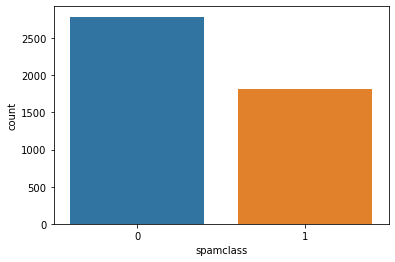

In [61]:
#Visulization about the number of spam vs. not spam
spambase.spamclass.value_counts()
sns.countplot(spambase.spamclass)
plt.show()

Spam: 1812 and not spam (Ham): 2788

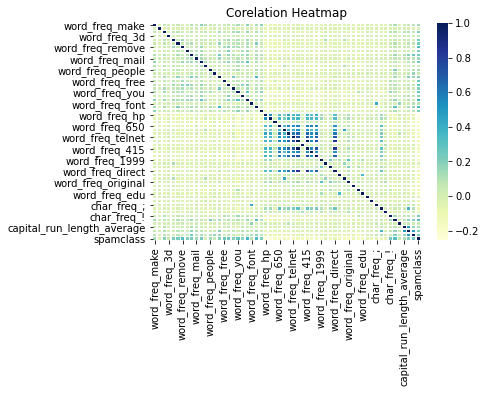

In [62]:
spambase.corr()
sns.heatmap(spambase.corr(),cmap="YlGnBu",linewidths=.5)
plt.title('Corelation Heatmap')
plt.show()

We divide the data-set into a training set and test set to get accurate results.

In [63]:
#Split dataset as 70% of training and 30% of test
random_state = 512

#separate the target variable from the input variables

X = spambase.loc[:,spambase.columns != 'spamclass']
y = spambase.loc[:,spambase.columns == 'spamclass']

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=random_state)

# Model 1: Decision Tree

A decision tree is a flowchart-like tree structure where an internal node represents feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome. The topmost node in a decision tree is known as the root node. It learns to partition on the basis of the attribute value. It partitions the tree in recursively manner call recursive partitioning. This flowchart-like structure helps us in decision making.

In [65]:
from sklearn.tree import DecisionTreeClassifier

# Create Decision Tree classifer object
dt = DecisionTreeClassifier()
#Train Decision Tree Classifer
trained_dt = dt.fit(X_train, y_train)
#Predict the response for test dataset
pred_dt = trained_dt.predict(X_test)

In [70]:
print("Decision Tree Accuracy:", accuracy_score(y_test, pred_dt))

Decision Tree Accuracy: 0.9130434782608695


we got a classification rate of 91.30%, considered as good accuracy.

In [67]:
#Create confusion matrix for decisiontreeclassifier
dt_cm = confusion_matrix(y_test, dt.predict(X_test))
pd.DataFrame(data = dt_cm, columns = ['Predicted Ham', 'Predicted Spam'],
            index = ['Actual Ham', 'Actual Spam'])

,Predicted Ham,Predicted Spam
Actual Ham,802,73
Actual Spam,47,458


# Model 2: Navie Bayes

Naive Bayes is among one of the very simple and powerful algorithms for classification based on Bayes Theorem with an assumption of independence among the predictors. The Naive Bayes classifier assumes that the presence of a feature in a class is not related to any other feature. Naive Bayes is a classification algorithm for binary and multi-class classification problems.
Bayes Theorem 

In [68]:
from sklearn.naive_bayes import MultinomialNB

# Create Naive Bayes classifer object
nb = MultinomialNB()
#Train Naive Bayes Classifer
train_nb = nb.fit(X_train, y_train)
#Predict the response for test dataset
pred_nb = train_nb.predict(X_test)

C:\Users\Hugo\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [69]:
print("Naive Bayes Accuracy:", accuracy_score(y_test, pred_nb))

Naive Bayes Accuracy: 0.7956521739130434


we got a classification rate of 79.56%, which is considered as good accuracy, but worse than the result Decision Tree and Random Forest.

In [39]:
#Create confusion matrix for Naive Bayes classifier
nb_cm = confusion_matrix(y_test, nb.predict(X_test))
pd.DataFrame(data = nb_cm, columns = ['Predicted Ham', 'Predicted Spam'],
            index = ['Actual Ham', 'Actual Spam'])

,Predicted Ham,Predicted Spam
Actual Ham,714,161
Actual Spam,121,384


# Model 3: Random Forest

Random forests is a supervised learning algorithm. It can be used both for classification and regression. It is also the most flexible and easy to use algorithm. A forest is comprised of trees. It is said that the more trees it has, the more robust a forest is. Random forests creates decision trees on randomly selected data samples, gets prediction from each tree and selects the best solution by means of voting. It also provides a pretty good indicator of the feature importance.

In [29]:
from sklearn.ensemble import RandomForestClassifier

# Create Random Forest classifer object
rf = RandomForestClassifier()
#Train Random Forest Classifer
train_rf = rf.fit(X_train, y_train)
#Predict the response for test dataset
pred_rf = train_rf.predict(X_test)

<ipython-input-29-d2b6464d1150>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  train_rf = rf.fit(X_train, y_train)


In [37]:
print("Random Forest Accuracy:", accuracy_score(y_test, pred_rf))

Random Forest Accuracy: 0.9550724637681159


we got a classification rate of 95.50%, which is considered as best accuracy in those models.

In [31]:
#Create confusion matrix for Random Forest classifier
rf_cm = confusion_matrix(y_test, rf.predict(X_test))
pd.DataFrame(data = rf_cm, columns = ['Predicted Ham', 'Predicted Spam'],
            index = ['Actual Ham', 'Actual Spam'])

,Predicted Ham,Predicted Spam
Actual Ham,850,25
Actual Spam,37,468


# Model 4: Support Vector Machine

A support vector machine (SVM) is a type of supervised machine learning classification algorithm. SVM offers very high accuracy compared to other classifiers such as logistic regression, and decision trees. It is known for its kernel trick to handle nonlinear input spaces. It is used in a variety of applications such as face detection, intrusion detection, classification of emails, news articles and web pages, classification of genes, and handwriting recognition.

In [33]:
from sklearn.svm import SVC

# Create Support Vector Machine classifer object
svm = SVC()
#Train Support Vector Machine Classifer
train_svm = svm.fit(X_train, y_train)
#Predict the response for test dataset
pred_svm = train_svm.predict(X_test)

C:\Users\Hugo\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [34]:
print("SVM Accuracy:", accuracy_score(y_test, pred_svm))

SVM Accuracy: 0.7123188405797102


we got a classification rate of 71.23%, which is considered as the worst accuracy in those models.

In [35]:
#Create confusion matrix for Random Forest classifier
svm_cm = confusion_matrix(y_test, svm.predict(X_test))
pd.DataFrame(data = svm_cm, columns = ['Predicted Ham', 'Predicted Spam'],
            index = ['Actual Ham', 'Actual Spam'])

,Predicted Ham,Predicted Spam
Actual Ham,728,147
Actual Spam,250,255


#  K-Nearest Neighbors algorithm

The K-nearest neighbors (KNN) algorithm is a type of supervised machine learning algorithms. KNN is extremely easy to implement in its most basic form, and yet performs quite complex classification tasks. It is a lazy learning algorithm since it doesn't have a specialized training phase. Rather, it uses all of the data for training while classifying a new data point or instance. KNN is a non-parametric learning algorithm, which means that it doesn't assume anything about the underlying data. This is an extremely useful feature since most of the real world data doesn't really follow any theoretical assumption e.g. linear-separability, uniform distribution, etc.

In [45]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN classifer object
knn = KNeighborsClassifier()
#Train KNN Classifer
train_knn = knn.fit(X_train, y_train)
#Predict the response for test dataset
pred_knn = train_knn.predict(X_test)

<ipython-input-45-89472d4adf2b>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  train_knn = knn.fit(X_train, y_train)


In [54]:
print("KNN Accuracy:", accuracy_score(y_test, pred_knn))

KNN Accuracy: 0.8050724637681159


we got a classification rate of 80.50%, which is considered as good accuracy in those models.

In [48]:
#Create confusion matrix for Random Forest classifier
knn_cm = confusion_matrix(y_test, knn.predict(X_test))
pd.DataFrame(data = knn_cm, columns = ['Predicted Ham', 'Predicted Spam'],
            index = ['Actual Ham', 'Actual Spam'])

,Predicted Ham,Predicted Spam
Actual Ham,737,138
Actual Spam,131,374


In [55]:
#Combine all result and show the difference
Combine = {'Decision Tree' : [accuracy_score(y_test, pred_dt)],
             'Naive Bayes' : [accuracy_score(y_test, pred_nb)],
             'Random Forest' : [accuracy_score(y_test, pred_rf)],
             'SVM' : [accuracy_score(y_test, pred_svm)],
             'KNN' : [accuracy_score(y_test, pred_knn)]}
pd.DataFrame (Combine)
pd.DataFrame(Combine, index=['Accuracy Rate'])

,Decision Tree,Naive Bayes,Random Forest,SVM,KNN
Accuracy Rate,0.913043,0.795652,0.955072,0.712319,0.805072


# Conclusion

In conclusion, we splited training and testing datasets from the UCI spam database and trained models inherent to Python's sklearn package. From the results, Random Forest has the highest accuracy (95.5.%), Decsion Tree has a better accuracy (91.30%), and SVM has the worst accurcy (71.23%).